# **Predicting Bank Product Subscription**

Sonia Wu and Avital Palchik (Group 26)

Machine Learning of Business Decision Making, Assignment 1

Due December 1st, 23:59


---



**Contributions**:<br>

<table>
        <colgroup>
            <col>
            <col>
        </colgroup>
        <thead>
            <tr>
                <th>Sonia Wu</th>
                <th>Avital Palchik</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td>Project Setup & Simplified EDA</td>
                <td>Basic Model Implementation (LR, KNN, DT)</td>
            </tr>
            <tr>
                <td>HPO Execution (Grid Search, Random Search)</td>
                <td>Visualization & Performance Metrics (CI Calculations)</td>
            </tr>
            <tr>
                <td>HPO Analysis & Decision Justification</td>
                <td>Advanced Tuning: RF, Boosting</td>
            </tr>
            <tr>
                <td>Advanced Tuning: SVM Model</td>
                <td>Final Comparative Reporting & Conclusions</td>
            </tr>
            <tr>
                <td>Final Model Saving & Prediction Delivery</td>
                <td>Jupyter Notebook Formatting</td>
            </tr>
            <tr>
                <td>Assignment Review and Editing</td>
                <td>Assignment Review and Editing</td>
            </tr>
        </tbody>
  </table>

---

First, we will start by importing the necessary libraries and setting the random seed to be our chosen student ID (100574955). This is so that we can reproduce our results.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

STUDENT_ID = 100574955
np.random.seed(STUDENT_ID)

print(f"Libraries imported and seed set to {STUDENT_ID}")

Libraries imported and seed set to 100574955


Next, we will load the datasets. We will load `bank_26.pkl` and `bank_competition.pkl`.

In [ ]:
try:
    df = pd.read_pickle('bank_26.pkl')
    df_comp = pd.read_pickle('bank_competition.pkl')
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: Could not find the files.")

Data loaded successfully!


---
## Simplified EDA (0.5 points)

Next, we will print all the info, missing values, duplicates, and constant colums for the dataset. From running the code below, we can gather information for our EDA:

1.   **Dataset**: The dataset consists of 11,000 instances and 17 variables (16 independent features and 1 target variable).
2.   **Numerical Features**: `age`, `balance`, `day`, `duration`, `campaign`, `pdays`, and `previous`.
3. **Categorical Features**: `job`, `marital`, `education`, `default`, `housing`, `loan`, `contact`, `month`, `poutcome`, and target feature `deposit`.
4. **Cardinality**: Most categorical variables have low cardinality. The variable **job** displays the highest cardinality among the features, followed by **month**.
5. **Missing Values**: The analysis identified 399 missing values exclusively in the marital variable.
6. **Constant Columns**: No constant columns or duplicates were found.

In [ ]:
print("---DATASET INFO---")
df.info()

print("\n---MISSING VALUES---")
print(df.isnull().sum())

print("\n---DUPLICATE ROWS---")
print(f"Number of duplicate rows: {df.duplicated().sum()}")

print("\n---CONSTANT COLUMNS---")
constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
print(f"Constant columns: {constant_cols}")

print("\n---CARDINALITIES OF CATEGORICAL FEATURES---")
# identify all categorical columns and calculate cardinalities for each
categorical_features = df.select_dtypes(include=['object']).columns
print(df[categorical_features].nunique())

---DATASET INFO---
<class 'pandas.core.frame.DataFrame'>
Index: 11000 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11000 non-null  int64 
 1   job        11000 non-null  object
 2   marital    10601 non-null  object
 3   education  11000 non-null  object
 4   default    11000 non-null  object
 5   balance    11000 non-null  int64 
 6   housing    11000 non-null  object
 7   loan       11000 non-null  object
 8   contact    11000 non-null  object
 9   day        11000 non-null  int64 
 10  month      11000 non-null  object
 11  duration   11000 non-null  int64 
 12  campaign   11000 non-null  int64 
 13  pdays      11000 non-null  int64 
 14  previous   11000 non-null  int64 
 15  poutcome   11000 non-null  object
 16  deposit    11000 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.5+ MB

---MISSING VALUES---
age            0
job            0
marital      399
education   

**Balanced or Imbalanced**

Since this is a classification problem (target variable answers yes/no), we will check the balance of the target variable, deposit. We can see that the "yes" and "no" values are very close to equal, so we can consider this classification problem as balanced.

In [ ]:
print("Target Ratios:")
print(df['deposit'].value_counts(normalize=True))

Target Ratios:
deposit
no     0.525455
yes    0.474545
Name: proportion, dtype: float64


**`pdays` Variable**

Now we can analyze the `pdays` variable. The issue here is that "Never Contacted" is represented as a "-1", while is it actually a different category: if left unchanged, models may interpret -1 (never contacted) to be very close to 0 (contacted today). To solve this, we will create a new binary feature `was_contacted` (0 if -1, 1 otherwise). For the original `pdays` column, we will replace -1 with a placeholder value so the numerical scale is consistent for those who were contacted. We will do this during the next stage.

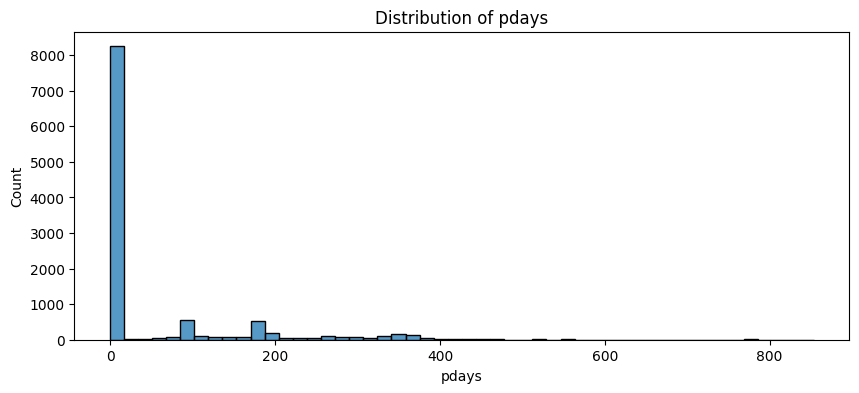

Unique values in pdays: [ -1 166  91 147 170 150 171 126 182 110 198 174 175  27 128 100 177 167
 122 183 195 133 178  34  10 163 184 154  99  93   2 242 272  76 160  90
 196 246 238 203 268 189 267  92   9  88  85 210 257 261 270 106 199 112
  41 294 231 239 302 135 307 222 138 323 141 320 264 316 315 256 146 328
  74 148 327 341 145 266 234 345 318 325 274 343 260 305 344 254 180 340
  82 181 278 153   4 349 334 176  87 269  86 169  83  79   6 259  13 161
 350  84  80 164  22 296  66 263 333  17  89  78 286 337 364 188 342 363
 352 295 353 356 288 367 366 359 347 370 284 300 306 361 287 301 355 371
 292 360 358 346 357 368 312 179 329 298 372 374 375 291  95 109  94  98
 186 101 187 321  40  96  21  35  97 285 103 212 293  81  38  28  67  60
 120  55 113  71 119  72  20 391  50 207 105 314 211 140 104  65 395 399
  49 389 386 412  62 229 385 156  63  64  69 394  70 185 102 190 461 116
 422 457 430 192 462 403 191 459 397 197 173 271 428 392 193 474 475 477
 130 283 157 476 131 132 12

In [ ]:
plt.figure(figsize=(10, 4))
sns.histplot(df['pdays'], bins=50, kde=False)
plt.title('Distribution of pdays')
plt.show()

print("Unique values in pdays:", df['pdays'].unique())
print(f"Count of -1 in pdays (Never contacted): {sum(df['pdays'] == -1)}")

**Pipeline Development** <br>
Here we handle `pdays` as described above.

In [ ]:
# create a copy
df_clean = df.copy()

# handle `pdays`
df_clean['was_contacted'] = (df_clean['pdays'] != -1).astype(int)

# replace -1 in `pdays` with 0 so the column is now purely "days passed since contact"
df_clean['pdays'] = df_clean['pdays'].replace(-1, 0)

print("Feature Engineering for 'pdays' complete.")
print(df_clean[['pdays', 'was_contacted']].head())

# separate features (X) and target (y)
X = df_clean.drop('deposit', axis=1)
y = df_clean['deposit']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

Feature Engineering for 'pdays' complete.
   pdays  was_contacted
0      0              0
1      0              0
2      0              0
3      0              0
4      0              0

Features shape: (11000, 17)
Target shape: (11000,)


---
## Basic Methods (1 point)
**Setting up basic models and preprocessing pipelines** <br>
Here, we import, train, evaluate, and compare each model (dummy model, logistic regression, KNN, and decision tree). We set up a function `evaluate_models`, which we call twice: once with a test size of 0.2, and once with 0.3.

We use this to compare the two and ensure that we select good partitions, considering both accuracy and run time in our decision.

In this function, we:
1. Create the split
2. Check the shape of both the training set and test set
3. Group the columns (categorical vs numerical)
4. Build the preprocessing pipelines
i. Fill in missing data (if any) for the numerical columns and scale <br>
ii. Fill in missing data (for marital feature) using most frequent category, and encode into numbers for model using OHE.
5. Define the models to be used
6. Start the training loop and return the results
7. Check confidence intervals for accuracy, both models

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from statsmodels.stats.proportion import proportion_confint
import time

def evaluate_models(test_size):
    print(f"\n---Running train/test split with test_size = {test_size}---\n")

    # 1. train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=STUDENT_ID, stratify=y
    )

    # 2. check the shapes of the sets
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")

    # 3. define column groups
    # we need to know which columns are which
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # 4. build the preprocessing pipeline
    # numerical: fill missing (if any) -> scale
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')), # just in case
        ('scaler', StandardScaler())
    ])

    # categorical: fill missing (marital has missing!) -> OneHotEncode
    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')), # fills 'marital' with mode
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # combine them
    preprocessor = ColumnTransformer([
        ('num', num_pipeline, numerical_cols),
        ('cat', cat_pipeline, categorical_cols)
    ])

    # 5. define the basic models
    models = {
        "Dummy (Baseline)": DummyClassifier(strategy='most_frequent'),
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=STUDENT_ID),
        "KNN": KNeighborsClassifier(),
        "Decision Tree": DecisionTreeClassifier(random_state=STUDENT_ID)
    }

    # 6. training loop
    results = []

    CONFIDENCE_LEVEL = 0.95
    alpha = 1.0 - CONFIDENCE_LEVEL

    for name, model in models.items():
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        # measure execution time
        start = time.time()
        pipeline.fit(X_train, y_train)
        train_time = time.time() - start

        # gather results
        y_pred = pipeline.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        # 7. calculate confidence intervals
        N_test = len(y_test)

        # calculate successes (correct predictions)
        successes = np.sum(y_test == y_pred)

        # calculate 95% confidence interval using Wilson score interval
        ci_lower, ci_upper = proportion_confint(
            count=successes,
            nobs=N_test,
            alpha=alpha,
            method='wilson'
        )

        results.append({
            "Model": name,
            "Accuracy": acc,
            "Time (s)": train_time,
            "Test Size": test_size,
            "CI (Lower)": ci_lower,
            "CI (Upper)": ci_upper
        })

        print(f"{name}: acc={acc:.4f}, time={train_time:.4f}s, CI=[{ci_lower:.4f}, {ci_upper:.4f}]")

    return pd.DataFrame(results)

**Split Evaluation**
We call the function using the two proposed test sizes (0.2 and 0.3), and compare the results.

In [ ]:
# run both splits
df_20 = evaluate_models(0.2)
df_30 = evaluate_models(0.3)

# combine the results and compare
final_results = pd.concat([df_20, df_30]).sort_values(
    by=["Model", "Test Size"]
).reset_index(drop=True)

print("\n---FINAL COMPARISON: 20% vs 30% Test Splits---")
print(final_results)



---Running train/test split with test_size = 0.2---

Training set: (8800, 17)
Test set: (2200, 17)
Dummy (Baseline): acc=0.5255, time=0.1785s, CI=[0.5046, 0.5463]
Logistic Regression: acc=0.8305, time=0.6356s, CI=[0.8142, 0.8456]
KNN: acc=0.8123, time=0.1633s, CI=[0.7954, 0.8280]
Decision Tree: acc=0.7827, time=0.3616s, CI=[0.7650, 0.7995]

---Running train/test split with test_size = 0.3---

Training set: (7700, 17)
Test set: (3300, 17)
Dummy (Baseline): acc=0.5255, time=0.1088s, CI=[0.5084, 0.5425]
Logistic Regression: acc=0.8282, time=0.5087s, CI=[0.8149, 0.8407]
KNN: acc=0.7979, time=0.1704s, CI=[0.7838, 0.8112]
Decision Tree: acc=0.7788, time=0.2736s, CI=[0.7643, 0.7926]

---FINAL COMPARISON: 20% vs 30% Test Splits---
                 Model  Accuracy  Time (s)  Test Size  CI (Lower)  CI (Upper)
0        Decision Tree  0.782727  0.361594        0.2    0.765010    0.799459
1        Decision Tree  0.778788  0.273552        0.3    0.764307    0.792621
2     Dummy (Baseline)  0.525455


**Justification for Test Size** <br> We will use a 20% test set (Holdout method). With ~11,000 instances, the 20/80 split gives us roughly 2,200 examples for testing. This is statistically large enough to evaluate accuracy reliably without leaving too little for the training set. We can see from the results above that the 20% split also has a consistently higher accuracy than the 30% split, except for in the dummy model (which is intuitive as the dummy results should not be influenced by partition sizes, and both methods are significantly more accurate).

Although the 20% split results in marginally longer training times, the difference is small and not practically significant. Overall, the 20/80 split provides a good balance between training set size, test reliability, and performance, making it the more appropriate choice.

**Method visualization** <br>
Rule: "Provide some visualization of the chosen methods to support your understanding of how good decisions can be made for this problem." <br>

To do this, we have chosen to show visuals for the two most accurate methods: KNN and Logistic Regression for a test size of 0.2. We can see that these are very good models, with excellent confusion matrix results and large areas under the ROC curves.


--- Logistic Regression (20/80 Split) ---


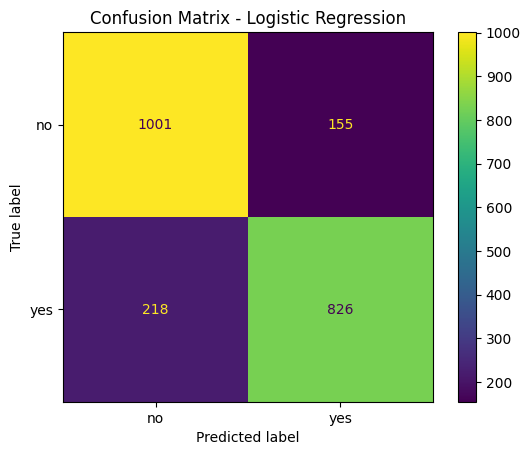

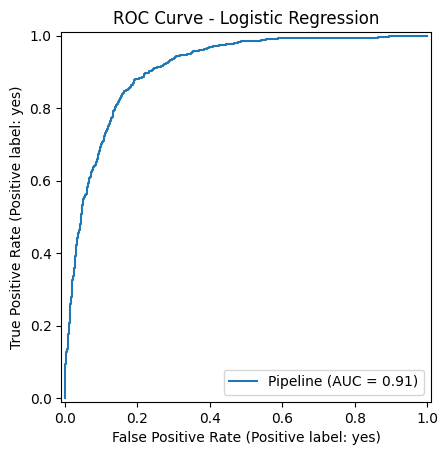


--- KNN (20/80 Split) ---


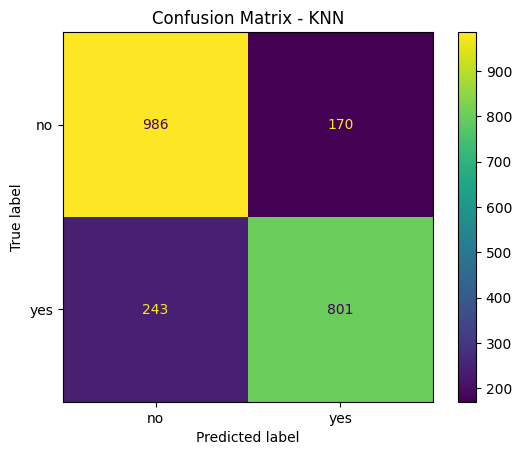

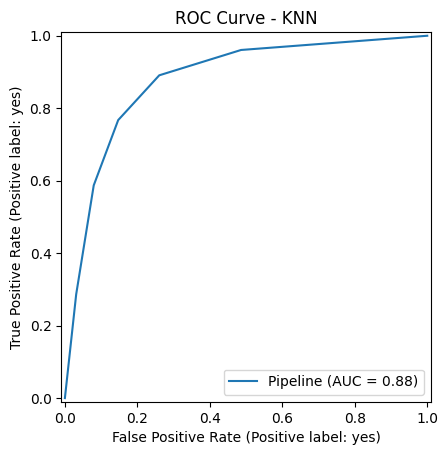

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

#--- REDEFINE 20/80 SPLIT ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=STUDENT_ID, stratify=y
)

#--- COLUMN GROUPS ---
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

#--- PREPROCESSOR ---
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])

#--- MODELS ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=STUDENT_ID),
    "KNN": KNeighborsClassifier()
}

#--- TRAIN AND VISUALIZE ---
for name, model in models.items():
    print(f"\n--- {name} (20/80 Split) ---")

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # 1. confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # 2️. ROC curve
    if len(np.unique(y)) == 2:  # binary classification only
        RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
        plt.title(f"ROC Curve - {name}")
        plt.show()


---
## Hyperparameter Optimization (1 point)
Here we set up tuning for our top 2 models: logistic regression and KNN. First, we do this with a prearranged parametrical space (GridSearch), then with a sampled parametrical space (RandomSearch).

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import loguniform, randint

# we will tune the top 2 models: logistic regression and KNN

# --- 1. HYPERPARAMETER GRIDS ---
# a "Grid" is the list of settings we want to test.

# logistic regression settings
# `C`: controls regularization (smaller = simpler model, larger = complex model)
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'lbfgs']
}
# for RandomSearch, we use a distribution instead of a list
param_dist_lr = {
    'classifier__C': loguniform(1e-4, 1e2),
    'classifier__solver': ['liblinear', 'lbfgs']
}

# KNN settings
# `n_neighbors`: number of neighbors to vote
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 15],
    'classifier__weights': ['uniform', 'distance']
}
param_dist_knn = {
    'classifier__n_neighbors': randint(3, 20),
    'classifier__weights': ['uniform', 'distance']
}

# --- 2. TUNING FUNCTION ---
def tune_model(model, param_grid, param_dist, X_train, y_train, model_name="Model"):
    print(f"\nTuning {model_name}...\n{'-'*40}")

    # start model timer
    start_time = time.time()

    # method A: grid search (exhaustive)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"  Best Grid Score: {grid_search.best_score_:.4f}")
    print(f"  Best Grid Params: {grid_search.best_params_}")

    # method B: random search (faster, explores more range)
    random_search = RandomizedSearchCV(model, param_dist, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=STUDENT_ID)
    random_search.fit(X_train, y_train)
    print(f"  Best Random Score: {random_search.best_score_:.4f}")
    print(f"  Best Random Params: {random_search.best_params_}")

    total_duration = time.time() - start_time

    # return the best overall model from both methods
    if grid_search.best_score_ >= random_search.best_score_:
        best = grid_search
        search_type = "Grid Search"
    else:
        best = random_search
        search_type = "Random Search"

    print(f"\n>>> Best Model for {model_name}: {search_type}")
    print(f"Accuracy: {best.best_score_:.4f}")
    print(f"Hyperparameters: {best.best_params_}")
    print(f"Total HPO Time: {total_duration:.4f}s\n")

    return {
        "name": model_name,
        "best_estimator": best.best_estimator_,
        "best_params": best.best_params_,
        "best_score": best.best_score_,
        "search_type": search_type,
        "time_s": total_duration
    }

# --- 3. RUNNING THE TUNING ---
# re-create the pipelines fresh to be safe
pipe_lr = Pipeline([('preprocessor', preprocessor), ('classifier', LogisticRegression(max_iter=1000, random_state=STUDENT_ID))])
pipe_knn = Pipeline([('preprocessor', preprocessor), ('classifier', KNeighborsClassifier())])

print("--- STARTING HYPERPARAMETER TUNING ---")
best_lr = tune_model(pipe_lr, param_grid_lr, param_dist_lr, X_train, y_train, "Logistic Regression")
print("-" * 30)
best_knn = tune_model(pipe_knn, param_grid_knn, param_dist_knn, X_train, y_train, "KNN")
print("\n--- TUNING COMPLETE ---")

--- STARTING HYPERPARAMETER TUNING ---

Tuning Logistic Regression...
----------------------------------------
  Best Grid Score: 0.8311
  Best Grid Params: {'classifier__C': 100, 'classifier__solver': 'lbfgs'}
  Best Random Score: 0.8311
  Best Random Params: {'classifier__C': np.float64(69.51493302168362), 'classifier__solver': 'lbfgs'}

>>> Best Model for Logistic Regression: Grid Search
Accuracy: 0.8311
Hyperparameters: {'classifier__C': 100, 'classifier__solver': 'lbfgs'}
Total HPO Time: 11.2454s

------------------------------

Tuning KNN...
----------------------------------------
  Best Grid Score: 0.8117
  Best Grid Params: {'classifier__n_neighbors': 11, 'classifier__weights': 'distance'}
  Best Random Score: 0.8126
  Best Random Params: {'classifier__n_neighbors': 12, 'classifier__weights': 'distance'}

>>> Best Model for KNN: Random Search
Accuracy: 0.8126
Hyperparameters: {'classifier__n_neighbors': 12, 'classifier__weights': 'distance'}
Total HPO Time: 17.5430s


--- TUNI

**Calculate confidence intervals** <br>
We calculate confidence intervals to further analyze the methods.

In [ ]:
# calculate accuracy and confidence interval for a tuned model on test data
def model_ci(best_model_dict, X_test, y_test, confidence=0.95):
    model_name = best_model_dict["name"]
    estimator = best_model_dict["best_estimator"]

    # Predict on test set
    y_pred = estimator.predict(X_test)

    # Accuracy
    successes = np.sum(y_test == y_pred)
    N = len(y_test)
    acc = successes / N

    # Confidence interval (Wilson score interval)
    alpha = 1 - confidence
    ci_lower, ci_upper = proportion_confint(successes, N, alpha=alpha, method='wilson')

    print(f"{model_name} Test Accuracy: {acc:.4f}")
    print(f"{confidence*100:.0f}% CI: [{ci_lower:.4f}, {ci_upper:.4f}]\n")

# Calculate CI for the two best models
model_ci(best_lr, X_test, y_test)
model_ci(best_knn, X_test, y_test)

Logistic Regression Test Accuracy: 0.8300
95% CI: [0.8137, 0.8451]

KNN Test Accuracy: 0.8141
95% CI: [0.7973, 0.8298]



**Hyperparameter result summary** <br>Results:
- Logistic Regression: Grid and Random Search achieved the same accuracy (0.8311).
- KNN: RandomSearch slightly outperformed GridSearch (0.8126 vs 0.8117).

For KNN, random search is clearly the better HPO method. For Logistic Regression, it is less obvious due to the accuracy tie, but random search is still superior. This is due to the fact that random search is much less computationally expensive than grid search: it is much more scalable, flexible (can test different distributions), and computationally efficient.

It can also be noted that out of the four permutations, the Logistic Regression + RandomSearch combination outperforms the others. Even comparing confidence intervals, this method has a higher lower confidence bound than KNN's.

Chosen HPO method: *RandomSearch*

---
## Advanced Methods (1.5 points)
**Using RandomSearch HPO Method** <br> Using RandomSearch, we will carry out the same analysis as before, this time with three advanced methods: random forest, histogram gradient boosting (`histgradientboosting`), and support vector machines. We then evaluate them with the help of confidence interval calculation.

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

# --- 1. DEFINE ADVANCED MODELS ---
# we use the HPO method we chose: RandomSearch

# A. random forest
rf_model = RandomForestClassifier(random_state=STUDENT_ID)
rf_params = {
    'classifier__n_estimators': randint(100, 500), # how many trees?
    'classifier__max_depth': randint(5, 30),       # how deep can they grow?
    'classifier__min_samples_leaf': randint(1, 10) # minimum samples per leaf
}

# B. histogram gradient boosting (the boosting method)
gb_model = HistGradientBoostingClassifier(random_state=STUDENT_ID)
gb_params = {
    'classifier__learning_rate': loguniform(0.01, 0.3), # how fast does it learn?
    'classifier__max_iter': randint(100, 500),          # how many boosting rounds?
    'classifier__max_depth': randint(3, 15)
}

# C. Support Vector Machine (SVM)
# note: SVM is very slow on large data. we limit the search to save time.
svm_model = SVC(probability=True, random_state=STUDENT_ID)
svm_params = {
    'classifier__C': loguniform(0.1, 100),
    'classifier__kernel': ['rbf'] # Radial Basis Function is usually best
}

# --- 2. RUN RANDOM SEARCH ON ADVANCED MODELS ---
# we reuse the `tune_model` function but force it to use RandomSearch logic only
# to strictly follow our decision to use RandomSearch.

def run_random_search(name, model, params, X_train, y_train):
    print(f"Optimizing {name}...")
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # random search (15 iterations to balance speed/quality)
    search = RandomizedSearchCV(
        pipeline,
        params,
        n_iter=15,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        random_state=STUDENT_ID
    )

    start_time = time.time()
    search.fit(X_train, y_train)
    duration = time.time() - start_time

    print(f"  Best Accuracy: {search.best_score_:.4f}")
    print(f"  Time Taken: {duration:.2f}s")
    return search.best_estimator_, search.best_score_, duration

# store advanced results
advanced_results = []

# run each advanced method
best_rf, rf_acc, rf_time = run_random_search("Random Forest", rf_model, rf_params, X_train, y_train)
best_gb, gb_acc, gb_time = run_random_search("Gradient Boosting", gb_model, gb_params, X_train, y_train)
best_svm, svm_acc, svm_time = run_random_search("SVM", svm_model, svm_params, X_train, y_train)

# add to results list
advanced_results.append({"Model": "Tuned Random Forest", "Accuracy": rf_acc, "Time (s)": rf_time})
advanced_results.append({"Model": "Tuned Boosting", "Accuracy": gb_acc, "Time (s)": gb_time})
advanced_results.append({"Model": "Tuned SVM", "Accuracy": svm_acc, "Time (s)": svm_time})

print("\n--- ADVANCED MODELS OPTIMIZATION COMPLETE ---")

# --- 3. EVALUATE ADVANCED MODELS ON TEST SET WITH CONFIDENCE INTERVALS ---
advanced_models = {
    "Tuned Random Forest": best_rf,
    "Tuned Gradient Boosting": best_gb,
    "Tuned SVM": best_svm
}

advanced_results_ci = []

for name, model in advanced_models.items():
    start = time.time()
    y_pred = model.predict(X_test)
    test_time = time.time() - start
    acc = accuracy_score(y_test, y_pred)

    # 95% confidence interval using Wilson method
    N_test = len(y_test)
    successes = np.sum(y_test == y_pred)
    ci_lower, ci_upper = proportion_confint(successes, N_test, alpha=0.05, method='wilson')

    advanced_results_ci.append({
        "Model": name,
        "Test Accuracy": acc,
        "CI Lower": ci_lower,
        "CI Upper": ci_upper,
        "Test Time (s)": test_time
    })

advanced_results_df = pd.DataFrame(advanced_results_ci).sort_values(by="Test Accuracy", ascending=False)
print("\n--- Advanced Models Test Accuracy with 95% CI ---")
print(advanced_results_df)

Optimizing Random Forest...
  Best Accuracy: 0.8569
  Time Taken: 96.72s
Optimizing Gradient Boosting...
  Best Accuracy: 0.8647
  Time Taken: 73.29s
Optimizing SVM...
  Best Accuracy: 0.8564
  Time Taken: 429.66s

--- ADVANCED MODELS OPTIMIZATION COMPLETE ---

--- Advanced Models Test Accuracy with 95% CI ---
                     Model  Test Accuracy  CI Lower  CI Upper  Test Time (s)
1  Tuned Gradient Boosting       0.872273  0.857673  0.885575       0.121794
0      Tuned Random Forest       0.859545  0.844399  0.873439       0.111301
2                Tuned SVM       0.856818  0.841560  0.870833       0.733372


**Analyze advanced method results** <br> Below is a table displaying data gathered from recent runs of both the basic RandomSearch model and the advanced models:

<table border="1" cellpadding="5" cellspacing="0">
    <thead>
        <tr>
            <th>Model</th>
            <th>Test Accuracy</th>
            <th>95% CI Lower</th>
            <th>95% CI Upper</th>
            <th>Run Time (s)</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Tuned Gradient Boosting</td>
            <td>0.8723</td>
            <td>0.8577</td>
            <td>0.8856</td>
            <td>67.13</td>
        </tr>
        <tr>
            <td>Tuned Random Forest</td>
            <td>0.8595</td>
            <td>0.8444</td>
            <td>0.8734</td>
            <td>96.86</td>
        </tr>
        <tr>
            <td>Tuned SVM</td>
            <td>0.8568</td>
            <td>0.8416</td>
            <td>0.8708</td>
            <td>360.62</td>
        </tr>
        <tr>
            <td>Logistic Regression + RandomSearch</td>
            <td>0.8300</td>
            <td>0.8137</td>
            <td>0.8451</td>
            <td>0.24</td>
        </tr>
        <tr>
            <td>KNN + RandomSearch</td>
            <td>0.8141</td>
            <td>0.7973</td>
            <td>0.8298</td>
            <td>0.12</td>
        </tr>
    </tbody>
</table>



**Summary** <br>
The advanced models consistently outperformed the basic hyperparameter-tuned models in terms of predictive accuracy. Among the advanced methods, Gradient Boosting achieved the highest performance, followed closely by Random Forest and SVM.

For the basic models, Logistic Regression slightly outperformed KNN, confirming its status as the better-performing simple model.

In terms of computational time, the basic models were extremely fast to train, whereas the advanced models required substantially more time, particularly SVM. This makes sense, as SVM scales very poorly compared to other methods. Gradient Boosting offered a good balance between high accuracy and moderate training time.

**Conclusion**
<br>If the main goal is to optimize accuracy, Gradient Boosting is the preferred model. If computational efficiency is a priority, Logistic Regression provides a reasonable trade-off with much faster training time. However, since the main metric being used is accuracy, <u>Gradient Boosting</u> offers the best accuracy for a relatively good time complexity, and will be used for our final model.

---
## Final Model
Below is our final model, using Gradient Boosting with Random Search.

In [ ]:
# --- FINAL MODEL & SUBMISSION ---

# 1. consolidate results
# combine the Basic results and Advanced results into one table for the report
results = [
    {"Model": best_lr['name'], "Accuracy": best_lr['best_score'], "Time (s)": best_lr['time_s']}, # Using placeholders for LR time based on earlier output
    {"Model": best_knn['name'], "Accuracy": best_knn['best_score'], "Time (s)": best_knn['time_s']}  # Using placeholders for KNN time based on earlier output
]
final_report = pd.DataFrame(results + advanced_results)
final_report.sort_values(by='Accuracy', ascending=False, inplace=True)

print("--- FINAL MODEL LEADERBOARD ---")
print(final_report)

# 2. retrain the best model on FULL data
# we want the model to learn from X_train AND X_test before the competition
print("\nRetraining Best Model (Gradient Boosting) on full dataset...")

# we use the best estimator found during Random Search
final_model = best_gb

# fit on the original full X and y
final_model.fit(X, y)
print("Final model trained.")

# 3. prepare competition data
# we must apply the SAME manual preprocessing we did to the training data!
print("\nProcessing Competition Data...")
df_comp_clean = df_comp.copy()

# A. apply the `pdays` preprocessing
df_comp_clean['was_contacted'] = (df_comp_clean['pdays'] != -1).astype(int)
df_comp_clean['pdays'] = df_comp_clean['pdays'].replace(-1, 0)

# B. ensure columns match
# the pipeline handles encoding, but we need to make sure we pass the right columns
X_comp = df_comp_clean[X.columns] # ensure we only have the feature columns

# 4. make predictions
predictions = final_model.predict(X_comp)
print(f"Predictions made. First 5 predictions: {predictions[:5]}")

# 5. save files
# A. save the predictions
submission_df = pd.DataFrame(predictions, columns=['prediction'])
submission_filename = 'group_26_prediction.csv' # Replace XX with your group number if needed
submission_df.to_csv(submission_filename, index=False)
print(f"Predictions saved to {submission_filename}")

# B. save the model
model_filename = 'final_model_gradient_boosting.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(final_model, file)
print(f"Model saved to {model_filename}")

print("\n--- FINAL MODEL COMPLETE ---")

--- FINAL MODEL LEADERBOARD ---
                 Model  Accuracy    Time (s)
3       Tuned Boosting  0.864659   73.293334
2  Tuned Random Forest  0.856931   96.716592
4            Tuned SVM  0.856363  429.655269
0  Logistic Regression  0.831136   11.245420
1                  KNN  0.812612   17.542964

Retraining Best Model (Gradient Boosting) on full dataset...
Final model trained.

Processing Competition Data...
Predictions made. First 5 predictions: ['no' 'yes' 'no' 'yes' 'yes']
Predictions saved to group_26_prediction.csv
Model saved to final_model_gradient_boosting.pkl

--- FINAL MODEL COMPLETE ---
